<a href="https://colab.research.google.com/github/candle16/statcan-crime-analysis/blob/main/Canada_Crime_Rate_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Canada Crime Rate Analysis (2000-2024)

This notebook analyzes crime rate trends in Canada using Statistics Canada data (Table 35-10-0177-01).

**Outputs:**
1. Line graph showing crime rate trends (2000-2024) for total crime, top violent crime, and top property crime
2. Table ranking Top 20 violent Criminal Code violations in 2024 with growth metrics
3. Table ranking Top 20 property violations in 2024 with growth metrics

**Data Source:** [Statistics Canada Table 35-10-0177-01](https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=3510017701)

In [1]:
# Install required packages
!pip install -q pandas matplotlib requests openpyxl

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import zipfile
from io import BytesIO
from pathlib import Path
from IPython.display import display, HTML

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Fetch Crime Rate Data from Statistics Canada

In [10]:
# Statistics Canada Table 35-10-0177-01: Incident-based crime statistics
TABLE_ID = "35100177"

# Construct download URL for the full table as a ZIP file
# This pattern is often more reliable for downloading entire tables from StatCan
download_url = f"https://www150.statcan.gc.ca/n1/tbl/csv/{TABLE_ID}-eng.zip"

print(f"Downloading data from Statistics Canada (Table {TABLE_ID})... ")

try:
    response = requests.get(download_url, timeout=60)
    response.raise_for_status()

    # Add a check for content size and type for debugging
    print(f"Response status code: {response.status_code}")
    print(f"Response content type: {response.headers.get('Content-Type')}")
    print(f"Response content length: {len(response.content):,} bytes")

    # The data is expected to be a ZIP file, extract the CSV from it
    with zipfile.ZipFile(BytesIO(response.content), 'r') as zf:
        # Get list of files in zip; usually one CSV with the table ID
        csv_file_name = [name for name in zf.namelist() if name.startswith(TABLE_ID) and name.endswith('.csv')][0]
        df = pd.read_csv(zf.open(csv_file_name))

    print(f"Data loaded: {len(df):,} rows, {len(df.columns)} columns")
    print(f"Time period: {df['REF_DATE'].min()} to {df['REF_DATE'].max()}")

except Exception as e:
    print(f"Error: {e}")
    raise

Response status code: 200
Response content type: application/zip
Response content length: 100,034,910 bytes


/tmp/ipython-input-3427053403.py:23: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(zf.open(csv_file_name))


Data loaded: 7,547,238 rows, 16 columns
Time period: 1998 to 2024


In [11]:
# Explore data structure
print("Columns:", df.columns.tolist())
print("\nSample data:")
df.head()

Columns: ['REF_DATE', 'GEO', 'DGUID', 'Violations', 'Statistics', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS']

Sample data:


,REF_DATE,GEO,DGUID,Violations,Statistics,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1998,Canada,2021A000011124,"Total, all violations [0]",Actual incidents,Number,223,units,0,v44348247,1.1.1,2688540.00,NaN,NaN,NaN,0
1,1998,Canada,2021A000011124,"Total, all violations [0]","Rate per 100,000 population",Rate,257,units,0,v44396346,1.1.2,8915.12,NaN,NaN,NaN,2
2,1998,Canada,2021A000011124,"Total, all violations [0]",Percentage change in rate,Percent,239,units,0,v44391402,1.1.3,NaN,..,NaN,NaN,2
3,1998,Canada,2021A000011124,"Total, all violations [0]",Percentage contribution to the Crime Severity ...,Percent,239,units,0,v1545644596,1.1.17,100.00,NaN,NaN,NaN,2
4,1998,Canada,2021A000011124,"Total, all violations [0]",Unfounded incidents,Number,223,units,0,v1000149311,1.1.15,NaN,..,NaN,NaN,0


In [12]:
# Check unique values in key columns
print("Unique GEO values:")
print(df['GEO'].unique())
print(f"\nUnique Statistics: {df['Statistics'].nunique()}")
print(df['Statistics'].unique())

Unique GEO values:
['Canada' 'Newfoundland and Labrador [10]'
 "St. John's, Newfoundland and Labrador [10001]"
 'Prince Edward Island [11]' 'Nova Scotia [12]'
 'Halifax, Nova Scotia [12205]' 'New Brunswick [13]'
 'Moncton, New Brunswick [13305]' 'Saint John, New Brunswick [13310]'
 'Quebec [24]' 'Saguenay, Quebec [24408]' 'Québec, Quebec [24421]'
 'Sherbrooke, Quebec [24433]' 'Trois-Rivières, Quebec [24442]'
 'Montréal, Quebec [24462]' 'Ottawa-Gatineau, Quebec part [24505]'
 'Ontario [35]' 'Ottawa-Gatineau, Ontario/Quebec [24505/35505]'
 'Ottawa-Gatineau, Ontario part [35505]' 'Kingston, Ontario [35521]'
 'Belleville-Quinte West, Ontario [35522]' 'Peterborough, Ontario [35529]'
 'Toronto, Ontario [35535]' 'Hamilton, Ontario [35537]'
 'St. Catharines-Niagara, Ontario [35539]'
 'Kitchener-Cambridge-Waterloo, Ontario [35541]'
 'Brantford, Ontario [35543]' 'Guelph, Ontario [35550]'
 'London, Ontario [35555]' 'Windsor, Ontario [35559]'
 'Barrie, Ontario [35568]' 'Greater Sudbury, Ontario [3

## 2. Filter and Prepare Data

In [13]:
# Filter for Canada-wide data and crime rate statistics
df_canada = df[
    (df['GEO'] == 'Canada') &
    (df['Statistics'] == 'Rate per 100,000 population')
].copy()

# Convert year
df_canada['Year'] = df_canada['REF_DATE'].astype(int)

# Filter for 2000-2024
df_canada = df_canada[df_canada['Year'].between(2000, 2024)]

# Remove rows with missing values
df_canada = df_canada[df_canada['VALUE'].notna()]

print(f"Filtered data: {len(df_canada):,} rows")
print(f"Years: {df_canada['Year'].min()} to {df_canada['Year'].max()}")
print(f"Unique violations: {df_canada['Violations'].nunique()}")

Filtered data: 6,161 rows
Years: 2000 to 2024
Unique violations: 312


In [14]:
# Explore violation categories
print("Sample violation types:")
violations = df_canada['Violations'].unique()
for v in violations[:30]:
    print(f"  - {v}")

Sample violation types:
  - Total, all violations [0]
  - Total, all Criminal Code violations (including traffic) [25]
  - Total, all Criminal Code violations (excluding traffic) [50]
  - Total violent Criminal Code violations [100]
  - Homicide [110]
  - Murder, first degree [1110]
  - Murder, second degree [1120]
  - Manslaughter [1130]
  - Infanticide [1140]
  - Total other violations causing death [120]
  - Criminal negligence causing death [1150]
  - Other related violations causing death [1160]
  - Attempted murder [1210]
  - Sexual assault, level 3, aggravated [1310]
  - Sexual assault, level 2, weapon or bodily harm [1320]
  - Sexual assault, level 1 [1330]
  - Total sexual violations against children [130]
  - Sexual interference [1345]
  - Invitation to sexual touching [1350]
  - Sexual exploitation [1355]
  - Assault, level 3, aggravated [1410]
  - Assault, level 2, weapon or bodily harm [1420]
  - Assault, level 1 [1430]
  - Total assaults against a peace officer [135]
  - 

In [15]:
# Define categories based on Statistics Canada classification
# Violent crimes are typically under "Violent Criminal Code violations"
# Property crimes are under "Property crime"

# Find key aggregates
total_crime_patterns = ['Total Criminal Code violations (excluding traffic)', 'Total, all Criminal Code violations']
violent_category = 'Total violent Criminal Code violations'
property_category = 'Total property crime'

# Check what exists
print("Looking for key categories...")
for pattern in total_crime_patterns + [violent_category, property_category]:
    matches = df_canada[df_canada['Violations'].str.contains(pattern, case=False, na=False, regex=False)]
    if len(matches) > 0:
        print(f"Found: '{pattern}' - {len(matches)} rows")

Looking for key categories...
Found: 'Total, all Criminal Code violations' - 50 rows
Found: 'Total violent Criminal Code violations' - 25 rows
Found: 'Total property crime' - 25 rows


In [16]:
# List all violations to identify violent and property crimes
print("All unique violations:")
for i, v in enumerate(sorted(violations), 1):
    print(f"{i:3}. {v}")

All unique violations:
  1. Abduction under age 14, by parent or guardian [1560]
  2. Abduction under the age 14 contravening a custody order [1550]
  3. Abduction under the age 14, not parent or guardian [1530]
  4. Abduction under the age 16 [1540]
  5. Advertising sexual services [1740]
  6. Advocating genocide [3550]
  7. Advocating/Promoting terrorism offence [3718]
  8. Agreement or Arrangement - sexual offence against child [1371]
  9. All other Criminal Code (includes Part XII.1 Criminal Code) [3890]
 10. Altering, removing or destroying Vehicle Identification Number (VIN) [2178]
 11. Anal intercourse [1375]
 12. Arson [2110]
 13. Arson, disregard for human life [1629]
 14. Assault, level 1 [1430]
 15. Assault, level 2, weapon or bodily harm [1420]
 16. Assault, level 3, aggravated [1410]
 17. Attempted murder [1210]
 18. Attempts, conspiracies, accessories (Part XIII Criminal Code) [3830]
 19. Bankruptcy Act [6100]
 20. Bawdy house [3110]
 21. Bestiality in presence of, or inc

## 3. Identify Crime Categories

In [17]:
# Define violent and property crime lists based on Criminal Code classification
# These are common Criminal Code violations categorized by type

violent_crimes = [
    'Homicide', 'Murder, first degree', 'Murder, second degree', 'Manslaughter',
    'Attempted murder', 'Conspiracy to commit murder',
    'Sexual assault, level 3, aggravated', 'Sexual assault, level 2, weapon or bodily harm',
    'Sexual assault, level 1', 'Sexual violations against children',
    'Assault, level 3, aggravated', 'Assault, level 2, weapon or bodily harm',
    'Assault, level 1', 'Assault peace officer',
    'Other assaults', 'Firearms - use of, discharge, pointing',
    'Robbery', 'Forcible confinement or kidnapping', 'Abduction',
    'Extortion', 'Criminal harassment', 'Uttering threats',
    'Indecent or harassing communications', 'Non-consensual distribution of intimate images'
]

property_crimes = [
    'Breaking and entering', 'Theft over $5,000 (non-motor vehicle)',
    'Theft of $5,000 or under (non-motor vehicle)', 'Theft of motor vehicle',
    'Possession of stolen property', 'Fraud', 'Identity fraud',
    'Mischief', 'Arson'
]

# Find actual matches in the data
def find_matching_violations(pattern_list, all_violations):
    """Find violations that contain any of the patterns."""
    matches = []
    for v in all_violations:
        for pattern in pattern_list:
            if pattern.lower() in v.lower():
                matches.append(v)
                break
    return matches

matched_violent = find_matching_violations(violent_crimes, violations)
matched_property = find_matching_violations(property_crimes, violations)

print(f"Matched violent crimes: {len(matched_violent)}")
print(f"Matched property crimes: {len(matched_property)}")

Matched violent crimes: 28
Matched property crimes: 16


In [18]:
# Get data for different crime categories
# Total crime
df_total = df_canada[df_canada['Violations'].str.contains('Total Criminal Code violations', case=False, na=False)]
if len(df_total) == 0:
    df_total = df_canada[df_canada['Violations'].str.contains('Total, all violations', case=False, na=False)]

# Violent crime total
df_violent_total = df_canada[df_canada['Violations'].str.contains('Total violent', case=False, na=False)]

# Property crime total
df_property_total = df_canada[df_canada['Violations'].str.contains('Total property', case=False, na=False)]

print(f"Total crime rows: {len(df_total)}")
print(f"Violent crime total rows: {len(df_violent_total)}")
print(f"Property crime total rows: {len(df_property_total)}")

if len(df_total) > 0:
    print(f"\nTotal crime category: {df_total['Violations'].iloc[0]}")
if len(df_violent_total) > 0:
    print(f"Violent total category: {df_violent_total['Violations'].iloc[0]}")
if len(df_property_total) > 0:
    print(f"Property total category: {df_property_total['Violations'].iloc[0]}")

Total crime rows: 25
Violent crime total rows: 25
Property crime total rows: 25

Total crime category: Total, all violations [0]
Violent total category: Total violent Criminal Code violations [100]
Property total category: Total property crime violations [200]


In [19]:
# Find top individual violent and property crimes in 2024
df_2024 = df_canada[df_canada['Year'] == 2024].copy()

# Filter for specific violent crimes (not totals)
df_violent_2024 = df_2024[
    df_2024['Violations'].isin(matched_violent) &
    ~df_2024['Violations'].str.contains('Total', case=False, na=False)
].copy()

# Filter for specific property crimes (not totals)
df_property_2024 = df_2024[
    df_2024['Violations'].isin(matched_property) &
    ~df_2024['Violations'].str.contains('Total', case=False, na=False)
].copy()

# Get top violent crime by rate
if len(df_violent_2024) > 0:
    top_violent = df_violent_2024.nlargest(1, 'VALUE')['Violations'].iloc[0]
    print(f"Top violent crime in 2024: {top_violent}")
else:
    top_violent = None
    print("No violent crimes found")

# Get top property crime by rate
if len(df_property_2024) > 0:
    top_property = df_property_2024.nlargest(1, 'VALUE')['Violations'].iloc[0]
    print(f"Top property crime in 2024: {top_property}")
else:
    top_property = None
    print("No property crimes found")

Top violent crime in 2024: Assault, level 1 [1430]
Top property crime in 2024: Mischief [2170]


## 4. Create Line Graph: Crime Rate Trends (2000-2024)

In [20]:
# Prepare data for line graph
# Get total crime trend
total_trend = df_total.groupby('Year')['VALUE'].first().reset_index()
total_trend.columns = ['Year', 'Total Crime Rate']

# Get top violent crime trend
if top_violent:
    violent_trend = df_canada[df_canada['Violations'] == top_violent].groupby('Year')['VALUE'].first().reset_index()
    violent_trend.columns = ['Year', 'Top Violent Crime Rate']
else:
    violent_trend = pd.DataFrame({'Year': [], 'Top Violent Crime Rate': []})

# Get top property crime trend
if top_property:
    property_trend = df_canada[df_canada['Violations'] == top_property].groupby('Year')['VALUE'].first().reset_index()
    property_trend.columns = ['Year', 'Top Property Crime Rate']
else:
    property_trend = pd.DataFrame({'Year': [], 'Top Property Crime Rate': []})

print("Data prepared for visualization")
print(f"Total crime years: {len(total_trend)}")
print(f"Violent crime years: {len(violent_trend)}")
print(f"Property crime years: {len(property_trend)}")

Data prepared for visualization
Total crime years: 25
Violent crime years: 25
Property crime years: 25


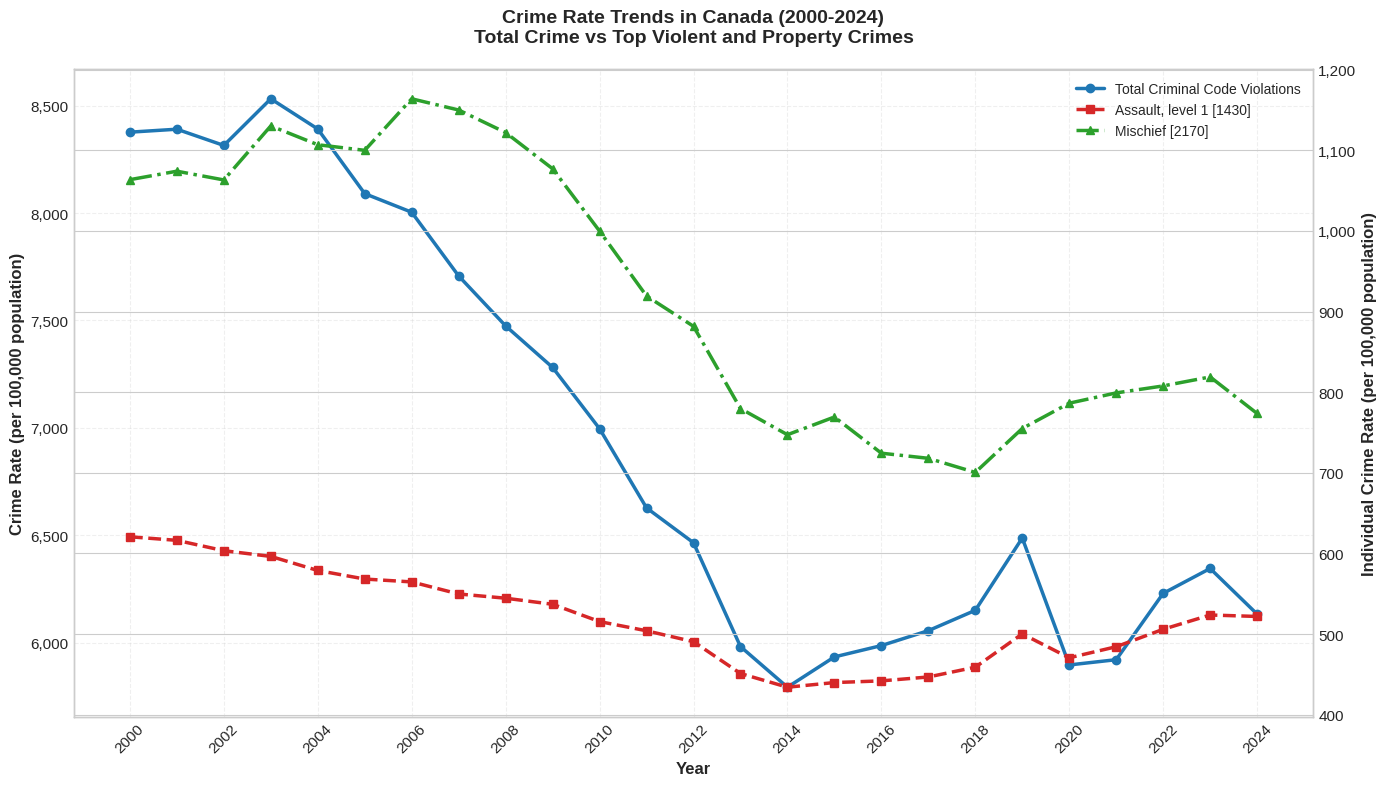


Line graph saved as 'crime_rate_trends_2000_2024.png'


In [21]:
# Create the line graph
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot total crime rate on primary y-axis
color_total = '#1f77b4'
line1 = ax1.plot(total_trend['Year'], total_trend['Total Crime Rate'],
                 marker='o', linewidth=2.5, markersize=6,
                 label='Total Criminal Code Violations', color=color_total)

ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Crime Rate (per 100,000 population)', fontsize=12, fontweight='bold')

# Create secondary y-axis for individual crimes (different scale)
ax2 = ax1.twinx()

# Plot top violent crime
color_violent = '#d62728'
if len(violent_trend) > 0:
    line2 = ax2.plot(violent_trend['Year'], violent_trend['Top Violent Crime Rate'],
                     marker='s', linewidth=2.5, markersize=6, linestyle='--',
                     label=f'{top_violent}', color=color_violent)

# Plot top property crime
color_property = '#2ca02c'
if len(property_trend) > 0:
    line3 = ax2.plot(property_trend['Year'], property_trend['Top Property Crime Rate'],
                     marker='^', linewidth=2.5, markersize=6, linestyle='-.',
                     label=f'{top_property}', color=color_property)

ax2.set_ylabel('Individual Crime Rate (per 100,000 population)', fontsize=12, fontweight='bold')

# Title
plt.title('Crime Rate Trends in Canada (2000-2024)\nTotal Crime vs Top Violent and Property Crimes',
          fontsize=14, fontweight='bold', pad=20)

# Format x-axis
years = list(range(2000, 2025, 2))
ax1.set_xticks(years)
ax1.set_xticklabels(years, rotation=45)

# Grid
ax1.grid(True, alpha=0.3, linestyle='--')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10, framealpha=0.9)

# Format y-axes with commas
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.savefig('crime_rate_trends_2000_2024.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLine graph saved as 'crime_rate_trends_2000_2024.png'")

## 5. Top 20 Violent Criminal Code Violations (2024)

In [22]:
# Get all violent crime data for 2024 and 2019
# Broader search for violent crimes
violent_keywords = [
    'homicide', 'murder', 'manslaughter', 'assault', 'sexual', 'robbery',
    'kidnapping', 'confinement', 'abduction', 'extortion', 'harassment',
    'threats', 'firearm', 'weapon', 'violence', 'violent'
]

def is_violent_crime(violation):
    """Check if violation is a violent crime."""
    v_lower = violation.lower()
    # Exclude totals and property crimes
    if 'total' in v_lower or 'property' in v_lower:
        return False
    return any(keyword in v_lower for keyword in violent_keywords)

# Get 2024 violent crimes
df_violent_2024 = df_2024[df_2024['Violations'].apply(is_violent_crime)].copy()

# Get 2019 data
df_2019 = df_canada[df_canada['Year'] == 2019].copy()
df_violent_2019 = df_2019[df_2019['Violations'].apply(is_violent_crime)].copy()

print(f"Violent crimes in 2024: {len(df_violent_2024)}")
print(f"Violent crimes in 2019: {len(df_violent_2019)}")

Violent crimes in 2024: 61
Violent crimes in 2019: 60


In [23]:
# Create Top 20 Violent Crimes table
# Get top 20 by 2024 crime rate
top_20_violent = df_violent_2024.nlargest(20, 'VALUE')[['Violations', 'VALUE']].copy()
top_20_violent.columns = ['Violation', 'Crime Rate 2024']

# Add 2019 rates and calculate growth
growth_data = []
for _, row in top_20_violent.iterrows():
    violation = row['Violation']
    rate_2024 = row['Crime Rate 2024']

    # Get 2019 rate
    rate_2019_data = df_violent_2019[df_violent_2019['Violations'] == violation]['VALUE']
    rate_2019 = rate_2019_data.iloc[0] if len(rate_2019_data) > 0 else 0

    # Calculate growth
    if rate_2019 > 0:
        growth = ((rate_2024 - rate_2019) / rate_2019) * 100
    else:
        growth = np.nan

    growth_data.append({
        'Rank': len(growth_data) + 1,
        'Violent Crime Violation': violation,
        'Crime Rate 2024': rate_2024,
        'Crime Rate 2019': rate_2019,
        'Growth 2019-2024 (%)': growth
    })

df_violent_table = pd.DataFrame(growth_data)
print("Top 20 Violent Criminal Code Violations table created")

Top 20 Violent Criminal Code Violations table created


In [24]:
# Display formatted table
print("=" * 100)
print("TOP 20 VIOLENT CRIMINAL CODE VIOLATIONS IN CANADA (2024)")
print("Ranked by Crime Rate (per 100,000 population)")
print("=" * 100)

# Format for display
df_violent_display = df_violent_table.copy()
df_violent_display['Crime Rate 2024'] = df_violent_display['Crime Rate 2024'].apply(lambda x: f'{x:,.1f}')
df_violent_display['Crime Rate 2019'] = df_violent_display['Crime Rate 2019'].apply(lambda x: f'{x:,.1f}')
df_violent_display['Growth 2019-2024 (%)'] = df_violent_display['Growth 2019-2024 (%)'].apply(
    lambda x: f'{x:+.1f}%' if pd.notna(x) else 'N/A'
)

# Style the table
styled_violent = df_violent_display.style.set_properties(**{
    'text-align': 'left',
    'font-size': '11px'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#d62728'), ('color', 'white'),
                                  ('font-weight', 'bold'), ('text-align', 'center'), ('padding', '8px')]},
    {'selector': 'td', 'props': [('padding', '6px'), ('border', '1px solid #ddd')]},
    {'selector': 'tr:nth-of-type(even)', 'props': [('background-color', '#f9f9f9')]}
]).hide(axis='index')

display(styled_violent)

# Save to CSV
df_violent_table.to_csv('top_20_violent_crimes_2024.csv', index=False)
print("\nTable saved as 'top_20_violent_crimes_2024.csv'")

TOP 20 VIOLENT CRIMINAL CODE VIOLATIONS IN CANADA (2024)
Ranked by Crime Rate (per 100,000 population)


Rank,Violent Crime Violation,Crime Rate 2024,Crime Rate 2019,Growth 2019-2024 (%)
1,"Assault, level 1 [1430]",521.8,500.2,+4.3%
2,Uttering threats [1627],234.6,214.9,+9.2%
3,"Assault, level 2, weapon or bodily harm [1420]",211.9,158.7,+33.5%
4,"Sexual assault, level 1 [1330]",87.1,80.6,+8.0%
5,Criminal harassment [1625],79.5,61.5,+29.1%
6,Robbery [1610],58.1,62.1,-6.4%
7,Possession of weapons [3375],50.0,40.9,+22.1%
8,Extortion [1620],31.8,11.3,+182.6%
9,Sexual interference [1345],20.6,19.6,+4.8%
10,"Assault, level 3, aggravated [1410]",10.3,10.6,-2.5%



Table saved as 'top_20_violent_crimes_2024.csv'


## 6. Top 20 Property Violations (2024)

In [25]:
# Get all property crime data
property_keywords = [
    'theft', 'break', 'entering', 'robbery', 'fraud', 'mischief', 'arson',
    'stolen property', 'motor vehicle', 'shoplifting', 'property'
]

def is_property_crime(violation):
    """Check if violation is a property crime."""
    v_lower = violation.lower()
    # Exclude totals
    if 'total' in v_lower:
        return False
    # Exclude violent crimes that might overlap
    if any(kw in v_lower for kw in ['assault', 'sexual', 'murder', 'homicide']):
        return False
    return any(keyword in v_lower for keyword in property_keywords)

# Get 2024 property crimes
df_property_2024 = df_2024[df_2024['Violations'].apply(is_property_crime)].copy()

# Get 2019 property crimes
df_property_2019 = df_2019[df_2019['Violations'].apply(is_property_crime)].copy()

print(f"Property crimes in 2024: {len(df_property_2024)}")
print(f"Property crimes in 2019: {len(df_property_2019)}")

Property crimes in 2024: 29
Property crimes in 2019: 29


In [26]:
# Create Top 20 Property Crimes table
top_20_property = df_property_2024.nlargest(20, 'VALUE')[['Violations', 'VALUE']].copy()
top_20_property.columns = ['Violation', 'Crime Rate 2024']

# Add 2019 rates and calculate growth
property_growth_data = []
for _, row in top_20_property.iterrows():
    violation = row['Violation']
    rate_2024 = row['Crime Rate 2024']

    # Get 2019 rate
    rate_2019_data = df_property_2019[df_property_2019['Violations'] == violation]['VALUE']
    rate_2019 = rate_2019_data.iloc[0] if len(rate_2019_data) > 0 else 0

    # Calculate growth
    if rate_2019 > 0:
        growth = ((rate_2024 - rate_2019) / rate_2019) * 100
    else:
        growth = np.nan

    property_growth_data.append({
        'Rank': len(property_growth_data) + 1,
        'Property Crime Violation': violation,
        'Crime Rate 2024': rate_2024,
        'Crime Rate 2019': rate_2019,
        'Growth 2019-2024 (%)': growth
    })

df_property_table = pd.DataFrame(property_growth_data)
print("Top 20 Property Violations table created")

Top 20 Property Violations table created


In [27]:
# Display formatted table
print("=" * 100)
print("TOP 20 PROPERTY VIOLATIONS IN CANADA (2024)")
print("Ranked by Crime Rate (per 100,000 population)")
print("=" * 100)

# Format for display
df_property_display = df_property_table.copy()
df_property_display['Crime Rate 2024'] = df_property_display['Crime Rate 2024'].apply(lambda x: f'{x:,.1f}')
df_property_display['Crime Rate 2019'] = df_property_display['Crime Rate 2019'].apply(lambda x: f'{x:,.1f}')
df_property_display['Growth 2019-2024 (%)'] = df_property_display['Growth 2019-2024 (%)'].apply(
    lambda x: f'{x:+.1f}%' if pd.notna(x) else 'N/A'
)

# Style the table
styled_property = df_property_display.style.set_properties(**{
    'text-align': 'left',
    'font-size': '11px'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#2ca02c'), ('color', 'white'),
                                  ('font-weight', 'bold'), ('text-align', 'center'), ('padding', '8px')]},
    {'selector': 'td', 'props': [('padding', '6px'), ('border', '1px solid #ddd')]},
    {'selector': 'tr:nth-of-type(even)', 'props': [('background-color', '#f9f9f9')]}
]).hide(axis='index')

display(styled_property)

# Save to CSV
df_property_table.to_csv('top_20_property_crimes_2024.csv', index=False)
print("\nTable saved as 'top_20_property_crimes_2024.csv'")

TOP 20 PROPERTY VIOLATIONS IN CANADA (2024)
Ranked by Crime Rate (per 100,000 population)


Rank,Property Crime Violation,Crime Rate 2024,Crime Rate 2019,Growth 2019-2024 (%)
1,Mischief [2170],773.5,754.9,+2.5%
2,"Theft $5,000 or under [2140]",573.8,601.9,-4.7%
3,"Shoplifting $5,000 or under [2143]",441.7,373.3,+18.3%
4,Fraud [2160],432.4,377.5,+14.5%
5,Breaking and entering [2120],291.6,426.6,-31.6%
6,"Theft $5,000 or under from a motor vehicle [2142]",274.7,526.9,-47.9%
7,Robbery [1610],58.1,62.1,-6.4%
8,Identity fraud [2166],51.7,53.1,-2.7%
9,"Theft over $5,000 [2130]",45.6,42.2,+8.0%
10,Dangerous operation of motor vehicle evading police [9133],29.8,16.8,+77.7%



Table saved as 'top_20_property_crimes_2024.csv'


## 7. Summary Statistics

In [28]:
# Print summary
print("=" * 80)
print("ANALYSIS SUMMARY")
print("=" * 80)

# Violent crimes summary
if len(df_violent_table) > 0:
    avg_growth_violent = df_violent_table['Growth 2019-2024 (%)'].mean()
    print(f"\nViolent Crimes (Top 20):")
    print(f"  - Average growth 2019-2024: {avg_growth_violent:+.1f}%")
    print(f"  - Highest crime rate: {df_violent_table['Violent Crime Violation'].iloc[0]}")
    print(f"    Rate: {df_violent_table['Crime Rate 2024'].iloc[0]:,.1f} per 100,000")

# Property crimes summary
if len(df_property_table) > 0:
    avg_growth_property = df_property_table['Growth 2019-2024 (%)'].mean()
    print(f"\nProperty Crimes (Top 20):")
    print(f"  - Average growth 2019-2024: {avg_growth_property:+.1f}%")
    print(f"  - Highest crime rate: {df_property_table['Property Crime Violation'].iloc[0]}")
    print(f"    Rate: {df_property_table['Crime Rate 2024'].iloc[0]:,.1f} per 100,000")

# Overall trend
if len(total_trend) > 0:
    rate_2000 = total_trend[total_trend['Year'] == 2000]['Total Crime Rate'].values
    rate_2024 = total_trend[total_trend['Year'] == 2024]['Total Crime Rate'].values
    if len(rate_2000) > 0 and len(rate_2024) > 0:
        overall_change = ((rate_2024[0] - rate_2000[0]) / rate_2000[0]) * 100
        print(f"\nOverall Crime Rate Change (2000-2024): {overall_change:+.1f}%")

print("\n" + "=" * 80)
print("Analysis complete. Files saved:")
print("  - crime_rate_trends_2000_2024.png")
print("  - top_20_violent_crimes_2024.csv")
print("  - top_20_property_crimes_2024.csv")
print("=" * 80)

ANALYSIS SUMMARY

Violent Crimes (Top 20):
  - Average growth 2019-2024: +16.2%
  - Highest crime rate: Assault, level 1 [1430]
    Rate: 521.8 per 100,000

Property Crimes (Top 20):
  - Average growth 2019-2024: +6.1%
  - Highest crime rate: Mischief [2170]
    Rate: 773.5 per 100,000

Overall Crime Rate Change (2000-2024): -26.8%

Analysis complete. Files saved:
  - crime_rate_trends_2000_2024.png
  - top_20_violent_crimes_2024.csv
  - top_20_property_crimes_2024.csv
